In [1]:
from __future__ import division
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings

import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
%matplotlib inline
warnings.filterwarnings(action='once')

data = pd.read_csv('data.csv')
n = len(data)
print("sample size: ", n)


sample size:  42


In [2]:
# Clean data (remove particpants who did the test in under 5mins)

minimum = 5 * 60 * 1000; # minumum duration of a test set to  5mins
start = data['data/timestamp/start']
end = data['data/timestamp/end']

data = data.loc[end-start > minimum]

n = len(data)
print("cleaned sample size: ", n)

cleaned sample size:  40


H0: μ1 = 0 "The estimate of the mean (μ1) equals zero(μ), meaning that people are accurate when making personal predictions"

HΑ: μ1 != 0 "Τhe estimate of the mean is different than zero (μ), meaning that people are not accurate"

Mean: 1.12
Median: 2.0


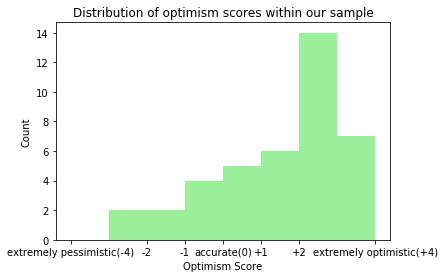

In [3]:
mu = 0; # population mean μ is zero (people are accurate)

optimism = data['data/survey/responses/1/0']

mean = round(np.mean(optimism),2)
median = round(np.median(optimism),2)

print("Mean:", mean)
print("Median:", median)

# Plot histogram

plt.hist(optimism, 8, range=[-4,4], color="lightgreen", alpha=0.9)
# sns.distplot(data['data/survey/responses/1/0'])
# plt.plot(optimism, stats.t(n).cdf(optimism), lw=3, label='t pdf')
plt.xlabel("Optimism Score")
plt.ylabel("Count")
plt.title("Distribution of optimism scores within our sample")
plt.xticks([-4,-2,-1,0,1,2,4],["extremely pessimistic(-4)","-2","-1","accurate(0)","+1","+2","extremely optimistic(+4)"])
plt.savefig('plots/fig1.png', format='png', dpi=1000)
plt.show()


In [4]:
# Check for normality 

shapiro = stats.shapiro(data['data/survey/responses/1/0'])
pvalue = round(shapiro[1],4)
print("SHAPIRO pvalue: ", pvalue) 

if pvalue > 0.05:
    print("\nThe distribution of the sample is not significantly different from a normal distribution.")
else:
    print("\nThe distribution of the sample is significantly different from a normal distribution.")

SHAPIRO pvalue:  0.0152

The distribution of the sample is significantly different from a normal distribution.


In [5]:
# Data is not normal so we use non-parametric tests

# One sample Wilcoxon against the known mean mu (non-parametric equivalent to one-sample t-test)
rank, pvalue = stats.wilcoxon(optimism-mu)

print('P value:')
print(round(pvalue,6))


P value:
0.000996


Age threshold: 30 

Size of younger sample: 26
Mean score younger sample 1.19
Median score younger sample: 2.0
Wilcoxon 1 sample against the μ=0: pvalue 0.00327
--------------------------------------------------
Size of older sample: 14
Mean score older sample 1.0
Median score older sample: 1.5
Wilcoxon 1 sample against the μ=0: pvalue 0.11995
--------------------------------------------------
mannwhit-statistic:  174.0
p-value:  0.41363
Younger sample prescibed optimism score was 
not signifficantly different than the older sample


C:\Users\Leda\Anaconda3\lib\site-packages\scipy\stats\stats.py:4975: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


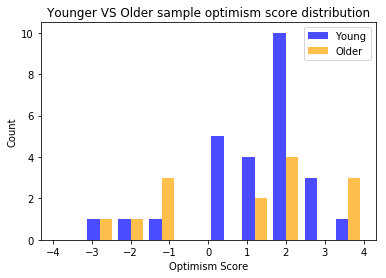

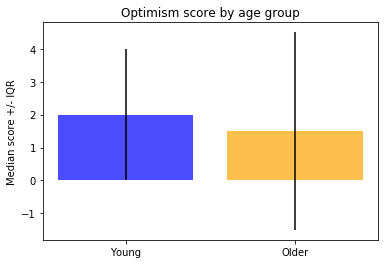

In [6]:
# Optimism by AGE
# Examine relationship between 2 age groups

threshold = 30
print("Age threshold:", threshold, "\n")

age = data['data/demographics/age']

young_sample = data.loc[age  < threshold]['data/survey/responses/1/0']
older_sample = data.loc[age  >= threshold]['data/survey/responses/1/0']

# n, mean, and 1-sample wilcoxon of younger group
print("Size of younger sample:", len(young_sample))
mean_young = np.mean(young_sample,0);
median_young = np.median(young_sample,0);
print("Mean score younger sample", round(mean_young,2))
print("Median score younger sample:", round(median_young,2))
wilcoxon1_young = stats.wilcoxon(young_sample-mu)
print("Wilcoxon 1 sample against the μ=0: pvalue", round(wilcoxon1_young.pvalue, 5))
print("-" *50)

# n, mean, and 1-sample wilcoxon of older group
print("Size of older sample:", len(older_sample))
mean_older = np.mean(older_sample,0);
median_older = np.median(older_sample,0);
print("Mean score older sample", round(mean_older,2))
print("Median score older sample:", round(median_older,2))
wilcoxon1_older = stats.wilcoxon(older_sample-mu)
print("Wilcoxon 1 sample against the μ=0: pvalue", round(wilcoxon1_older.pvalue, 5))
print("-" *50)

# Mann Whitney test, the non-parametric equivalent to the independent t-test 
mannwhit = stats.mannwhitneyu(young_sample,older_sample)
print("mannwhit-statistic: ", round(mannwhit.statistic, 5))
print("p-value: ", round(mannwhit.pvalue, 5))


if mannwhit.pvalue < 0.01:
    print("Younger sample prescibed optimism score was \ndifferent than the older sample with high significance")
elif mannwhit.pvalue < 0.05:
     print("Younger sample prescibed optimism score was \nsignifficantly different than the older sample")
elif mannwhit.pvalue >= 0.05:
    print("Younger sample prescibed optimism score was \nnot signifficantly different than the older sample")
    
# Plot histogram 

plt.hist([young_sample,older_sample],10,range=[-4,4],color=["blue","orange"], alpha=0.7)
plt.title("Younger VS Older sample optimism score distribution")
plt.xlabel("Optimism Score")
plt.ylabel("Count")
plt.legend(["Young","Older"])
plt.savefig('plots/fig2.png', format='png', dpi=1000)
plt.show()

# Plot boxplots

IQR_young = np.percentile(young_sample,75)-np.percentile(young_sample,25)
IQR_older = np.percentile(older_sample,75)-np.percentile(older_sample,25)

plt.bar([1,2],[median_young, median_older],color=["blue","orange"], alpha=0.7,
        yerr=[IQR_young,IQR_older],align='center')
plt.title('Optimism score by age group')
plt.xticks([1,2],["Young","Older"])
plt.ylabel("Median score +/- IQR")
plt.savefig('plots/fig3.png', format='png', dpi=1000)
plt.show()


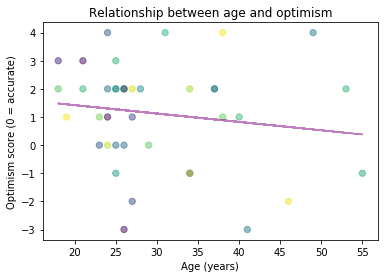

Spearnman Correlation Coefficient:  -0.16924 with p-value:  0.29648
There is a non-significant, weak negative linear relationship between age and optimism score.


In [7]:
# Age Optimism Correlation

# Least squares
A = np.vstack([age,np.ones(n)]).T
m,c = np.linalg.lstsq(A,optimism,rcond=None)[0]

colors = np.random.rand(n)
plt.scatter(age, optimism,s=40, c=colors, alpha=0.5)
plt.plot(age,age*m+c, color="purple", alpha=0.5)
plt.title('Relationship between age and optimism')
plt.xlabel('Age (years)')
plt.ylabel('Optimism score (0 = accurate)')
plt.savefig('plots/fig4.png', format='png', dpi=1000)
plt.show()

# We use the spearman correlation instead of the pearson one, since the data is not normal
inference = stats.spearmanr(age,optimism )
print("Spearnman Correlation Coefficient: ", round(inference[0], 5), "with p-value: ", round(inference[1], 5))

print("There is a non-significant, weak negative linear relationship between age and optimism score.")


Size of male sample: 19
Mean score of male sample 1.05
Median score male sample: 2.0
Wilcoxon 1 sample against the μ=0: pvalue 0.0579
--------------------------------------------------
Size of female sample: 18
Mean score female sample 1.5
Median score female sample: 2.0
Wilcoxon 1 sample against the μ=0: pvalue 0.00286
--------------------------------------------------
Size of other sample: 3
Mean score other gender sample -0.67
Median score other sample: -1.0
Wilcoxon 1 sample against the μ=0: pvalue 0.1573
--------------------------------------------------
Mann Whitney between male and female
mannwhit-statistic:  162.5
p-value:  0.40094


C:\Users\Leda\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


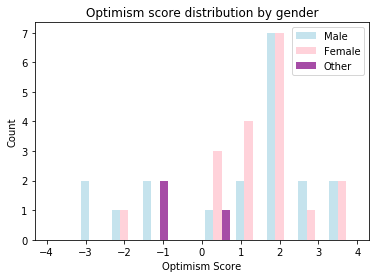

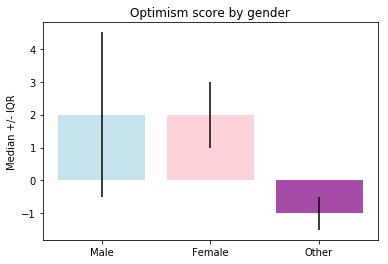

We notice that the mean and median of the participants identifying as 'other' gender are both negative, completely unrelated to the scores of the male and female groups.Even the IQR has no common values with thethe male and female participants ranges. Although the sample size is very small(n=3) so we cannot draw any conclusions,we think it is an important finding and worth further exploring it in a study with larger sample sizes.


In [8]:
# Optimism by GENDER

gender = data['data/demographics/gender']
male = data.loc[gender == 'male']['data/survey/responses/1/0']
female = data.loc[gender == 'female']['data/survey/responses/1/0']
other = data.loc[gender == 'other']['data/survey/responses/1/0']

mean_male = round(np.mean(male),3);
mean_female = round(np.mean(female),3);
mean_other = round(np.mean(other),3);
median_male = round(np.median(male),3);
median_female = round(np.median(female),3);
median_other = round(np.median(other),3);

# n, mean, and 1-sample wilcoxon of male group
print("Size of male sample:", len(male))
print("Mean score of male sample", round(mean_male,2))
print("Median score male sample:", round(median_male,2))
wilcoxon1_male = stats.wilcoxon(male-mu)
print("Wilcoxon 1 sample against the μ=0: pvalue", round(wilcoxon1_male.pvalue, 5))
print("-" *50)

# n, mean, and 1-sample wilcoxon of female group
print("Size of female sample:", len(female))
mean_female = np.mean(female,0);
median_female = np.median(female,0);
print("Mean score female sample", round(mean_female,2))
print("Median score female sample:", round(median_female,2))
wilcoxon1_female = stats.wilcoxon(female-mu)
print("Wilcoxon 1 sample against the μ=0: pvalue", round(wilcoxon1_female.pvalue, 5))
print("-" *50)

# n, mean, and 1-sample wilcoxon of other gender group
print("Size of other sample:", len(other))
mean_other = np.mean(other,0);
median_other = np.median(other,0);
print("Mean score other gender sample", round(mean_other,2))
print("Median score other sample:", round(median_other,2))
wilcoxon1_other = stats.wilcoxon(other-mu)
print("Wilcoxon 1 sample against the μ=0: pvalue", round(wilcoxon1_other.pvalue, 5))
print("-" *50)

# Mann Whitney test between male and females, the non-parametric equivalent to the independent t-test 
mannwhit = stats.mannwhitneyu(male,female)
print("Mann Whitney between male and female")
print("mannwhit-statistic: ", round(mannwhit.statistic, 5))
print("p-value: ", round(mannwhit.pvalue, 5))

    
# Plot histogram
plt.hist([male,female,other],10,range=[-4,4], color=["lightblue", "pink", "purple"], alpha=0.7)
plt.title("Optimism score distribution by gender")
plt.xlabel("Optimism Score")
plt.ylabel("Count")
plt.legend(["Male","Female", "Other"])
plt.savefig('plots/fig5.png', format='png', dpi=1000)
plt.show()

# Plot boxplots
IQR_male = np.percentile(male,75)-np.percentile(male,25)
IQR_female = np.percentile(female,75)-np.percentile(female,25)
IQR_other = np.percentile(other,75)-np.percentile(other,25)

plt.bar([1,2,3],[median_male, median_female, median_other], color=("lightblue","pink","purple"),alpha = 0.7,
        yerr=[IQR_male,IQR_female,IQR_other],align='center')
plt.title('Optimism score by gender')
plt.xticks([1,2,3],["Male","Female","Other"])
plt.ylabel("Median +/- IQR")
plt.savefig('plots/fig6.png', format='png', dpi=1000)
plt.show()

print("We notice that the mean and median of the participants identifying as 'other' gender are both negative, \
completely unrelated to the scores of the male and female groups.Even the IQR has no common values with the\
the male and female participants ranges. Although the sample size is very small(n=3) so we cannot draw any conclusions,\
we think it is an important finding and worth further exploring it in a study with larger sample sizes.")





Now we will explore the sample of people who scored low in the LOT (Life Orientation Test),that is people with a general pessimistic tendancy, as did in the replication study. We will as well compare this group with the sample of people who scored high in the LOT test.

Pessimists:

size:  10
mean: 1.4
median: 1.5
1 sample wilcoxon against μ=0: p-value:  0.02365
--------------------------------------------------
Optimists:

size: 20
mean: 1.45
median: 2.0
1 sample wilcoxon against μ=0: p-value:  0.01001
--------------------------------------------------
Pessimists VS Optimists:

Mann Whitney: p-value:  0.32421
Kruskal: p-value: 0.63212


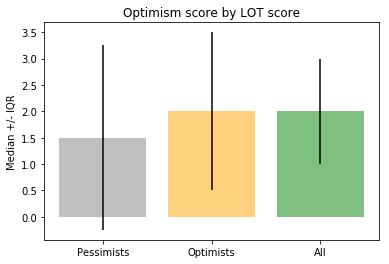


Conclusions:
The optimism score of the pessimists is significanlty different than the population mean.
(p-value: 0.02365 <0.05)
This agrees with the findings of the replication study, which found out that even pessimists prescribe optimism.

The optimism score of the optimiststs is also significanlty different than the population mean.
(p-value: 0.01001 <0.05)

Comparing the mean score of the pessimists and the optimists, we see that there is no significant difference between the optimism score of the two groups.


In [9]:
# Sample of people who scored low in the LOT ( pessimistic tendancy)

lot_sample1 = data.loc[:, 'data/lifeOrientationTest/0':'data/lifeOrientationTest/9']
lot_sample = data.loc[:, ['data/lifeOrientationTest/0','data/lifeOrientationTest/1','data/lifeOrientationTest/2','data/lifeOrientationTest/3','data/lifeOrientationTest/4','data/lifeOrientationTest/5','data/lifeOrientationTest/6','data/lifeOrientationTest/7','data/lifeOrientationTest/8','data/lifeOrientationTest/9','data/survey/responses/1/0']]

# New column with mean LOT score
lot_sample['meanLOT'] = lot_sample1.sum(axis=1)/10

# Create optimism and pessimism masks and get the two samples
pessimism = lot_sample['meanLOT'] < 3  # 3 is the neutral answer in the LOT scale
optimism = lot_sample['meanLOT'] > 3
pessimists = lot_sample.loc[pessimism]['data/survey/responses/1/0']
optimists = lot_sample.loc[optimism]['data/survey/responses/1/0']

# n, mean,median and 1-sample wilcoxon of pessimists group
print("Pessimists:\n")
print("size: ", len(pessimists))
mean_pessimist = round(np.mean(pessimists),2)
median_pessimist = round(np.median(pessimists),2)
print("mean:", mean_pessimist)
print("median:", median_pessimist)
wilcoxonP = stats.wilcoxon(pessimists-mu)
print("1 sample wilcoxon against μ=0: p-value: ", round(wilcoxonP.pvalue, 5))
# wilcoxonPSample = stats.wilcoxon(pessimists-mean)
# print "1 sample wilcoxon against mean=1.13: p-value: ", round(wilcoxonPSample.pvalue, 5)
print("-" *50)

# n, mean, median and 1-sample wilcoxon of optimists group
print("Optimists:\n")
print("size:", len(optimists))
mean_optimist = round(np.mean(optimists),2);
median_optimist = round(np.median(optimists,0),2);
print("mean:", mean_optimist)
print("median:", median_optimist)
wilcoxonOpt = stats.wilcoxon(optimists-mu)
print("1 sample wilcoxon against μ=0: p-value: ", round(wilcoxonOpt.pvalue, 5))
# wilcoxonOptSample = stats.wilcoxon(optimists-mean)
# print "1 sample wilcoxon against mean=1.13: p-value: ", round(wilcoxonOptSample.pvalue, 5)
print("-" *50)

# Mann Whitney test between optimists and pessimists, a non-parametric equivalent to the independent t-test 
mannwhit = stats.mannwhitneyu(pessimists,optimists)
print("Pessimists VS Optimists:\n")
print("Mann Whitney: p-value: ", round(mannwhit.pvalue, 5))

# Kruskal is another non-parametric equivalent to the independent t-test 
kruskal = stats.kruskal(pessimists, optimists);
print("Kruskal: p-value:", round (kruskal.pvalue,5))

# Plot boxplots (pessimists vs optimists vs all)
IQR_pessimists = np.percentile(pessimists,75)-np.percentile(pessimists,25)
IQR_optimists = np.percentile(optimists,75)-np.percentile(optimists,25)
IQR_all = np.percentile(optimism,75)-np.percentile(optimism,25)

plt.bar([1,2,3],[median_pessimist, median_optimist, median],color=["grey", "orange", "green"], alpha=0.5,
        yerr=[IQR_pessimists,IQR_optimists,IQR_all],align='center')
plt.title('Optimism score by LOT score')
plt.xticks([1,2,3],["Pessimists","Optimists","All"])
plt.ylabel("Median +/- IQR")
plt.savefig('plots/fig7.png', format='png', dpi=1000)
plt.show()

# Conclusions
print("\nConclusions:")
print("The optimism score of the pessimists is significanlty different than the population mean.")
print("(p-value:", round(wilcoxonP.pvalue, 5), "<0.05)")
print("This agrees with the findings of the replication study, which found out that even pessimists prescribe optimism.\n")

print("The optimism score of the optimiststs is also significanlty different than the population mean.")
print("(p-value:", round(wilcoxonOpt.pvalue, 5), "<0.05)\n")

print("Comparing the mean score of the pessimists and the optimists, we see that there is no significant difference between the optimism score of the two groups.")

 

Studying VS Not Studying:

Size: studying: 19 not studying: 21
Mean: studying: 0.84 not studying: 1.38
Median: studying: 1.0 not studying: 2.0
Wilcoxon against μ=0: studying: p-value: 0.10199
Wilcoxon against μ=0: not studying: p-value: 0.00176
Mann Whitney: p-value: 0.17954
Kruskal:  p-value: 0.35184

Conclusions:

The optimism score of the particapants who are studying is not significanlty different from the population mean(μ=0)!
(p-value: 0.10199 > 0.05)
On the other hand, the optimism score of the particapants who are not studying is significanlty different than the population mean.
(p-value: 0.00176 < 0.05)
According to our results, participants who are currenlty studying are actually the only group so far who prescibed more accuracy than optimism

However, when we comparing the optimism score of the two groups, we see that there is no significant differenceas the p-value of both the Mann Whitney and the Kruskal test is greater than 0.05.


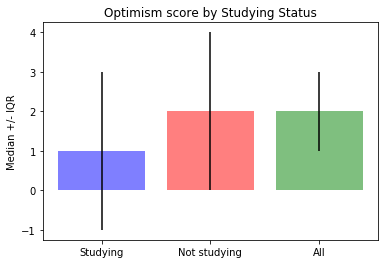

In [10]:
# Studying VS Not studying

studying = data['data/demographics/isStudying']
print("Studying VS Not Studying:\n")
study = data.loc[studying == True]['data/survey/responses/1/0']
notStudy = data.loc[studying == False]['data/survey/responses/1/0']

# n, mean, median 1-sample wilcoxon
print("Size: studying:", len(study), "not studying:", len(notStudy))
mean_study = round(np.mean(study),2);
mean_notStudy = round(np.mean(notStudy),2);
print("Mean: studying:", mean_study, "not studying:", mean_notStudy)
median_study = np.median(study);
median_notStudy = np.median(notStudy);
print("Median: studying:", median_study, "not studying:", median_notStudy)
wilcoxon1_study = stats.wilcoxon(study-mu)
wilcoxon1_notStudy = stats.wilcoxon(notStudy-mu)
print("Wilcoxon against μ=0: studying: p-value:", round(wilcoxon1_study[1], 5))
print("Wilcoxon against μ=0: not studying: p-value:", round(wilcoxon1_notStudy[1], 5))

#Mann-Whitney
mannwhit = stats.mannwhitneyu(study,notStudy)
print("Mann Whitney: p-value:", round(mannwhit.pvalue, 5))

# Kruskal
studying_krusckal = stats.kruskal(study, notStudy)
print("Kruskal:  p-value:", round(studying_krusckal.pvalue, 5))

# Conclusions
print("\nConclusions:\n")
print("The optimism score of the particapants who are studying is not significanlty different from the population mean(μ=0)!")
print("(p-value:", round(wilcoxon1_study[1], 5), "> 0.05)")
print("On the other hand, the optimism score of the particapants who are not studying is significanlty different than the population mean.")
print("(p-value:", round(wilcoxon1_notStudy[1], 5), "< 0.05)")
print("According to our results, participants who are currenlty studying are actually the only group so far who prescibed more accuracy than optimism\n")
print("However, when we comparing the optimism score of the two groups, we see that there is no significant difference\
as the p-value of both the Mann Whitney and the Kruskal test is greater than 0.05.")

# Plot boxplots (studying vs not studying vs all)
IQR_study = np.percentile(study,75)-np.percentile(study,25)
IQR_notStudy = np.percentile(notStudy,75)-np.percentile(notStudy,25)

plt.bar([1,2,3],[median_study, median_notStudy, median],color=["blue", "red", "green"], alpha=0.5,
        yerr=[IQR_study,IQR_notStudy,IQR_all],align='center')
plt.title('Optimism score by Studying Status')
plt.xticks([1,2,3],["Studying","Not studying","All"])
plt.ylabel("Median +/- IQR")
plt.savefig('plots/fig8.png', format='png', dpi=1000)
plt.show()






Working VS Not working:

size:working: 32 not working: 8
Mean:working 1.19 not working: 0.88
Median:working 2.0 not working: 1.0
Wilcoxon against μ=0: working: p-value: 0.00257
Wilcoxon against μ=0: not working: p-value: 0.16701
Mann Whitney: p-value: 0.27765
Kruskal: p-value: 0.54373

Conclusions:

The optimism score of the participants who are working is significanlty different from the population mean
(p-value: 0.00257 < 0.05)
On the other hand, the optimism score of the particapants who are not working is not significanlty        different than the population mean.
(p-value: 0.16701 > 0.05)
This result suggests that participants who are currenlty not working are more pessimistic and prescibed         more accuracy than optimism, although the sample size is very small (n=8)
However, when we comparing the optimism score of the two groups, we see that there is no significant differenceas the p-value of both the Mann Whitney and the Kruskal test is greater than 0.05.


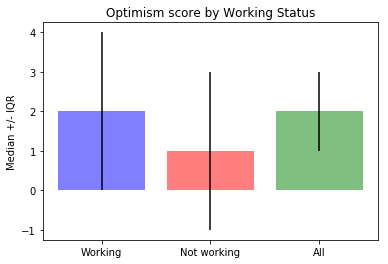

In [11]:
# Working VS Not working

working = data['data/demographics/isWorking']
print("Working VS Not working:\n")

work = data.loc[working == True ]['data/survey/responses/1/0']
notWork = data.loc[working == False]['data/survey/responses/1/0']

# n, mean, median 1-sample wilcoxon
print("size:working:", len(work), "not working:", len(notWork))
mean_work = round(np.mean(work),2)
mean_notWork = round(np.mean(notWork),2)
print("Mean:working", mean_work, "not working:", mean_notWork)
median_work = np.median(work)
median_notWork = np.median(notWork)
print("Median:working", median_work, "not working:", median_notWork)
wilcoxon1_work = stats.wilcoxon(work-mu)
wilcoxon1_notWork = stats.wilcoxon(notWork-mu)
print("Wilcoxon against μ=0: working: p-value:", round(wilcoxon1_work[1], 5))
print("Wilcoxon against μ=0: not working: p-value:", round(wilcoxon1_notWork[1], 5))

#Mann-Whitney
mannwhit = stats.mannwhitneyu(work,notWork)
print("Mann Whitney: p-value:", round(mannwhit.pvalue, 5))

# Kruskal 
working_kruskal = stats.kruskal(work, notWork)
print("Kruskal: p-value:", round(working_kruskal.pvalue,5))

# Conclusions
print("\nConclusions:\n")
print("The optimism score of the participants who are working is significanlty different from the population mean")
print("(p-value:", round(wilcoxon1_work[1], 5), "< 0.05)")
print("On the other hand, the optimism score of the particapants who are not working is not significanlty \
       different than the population mean.")
print("(p-value:", round(wilcoxon1_notWork[1], 5), "> 0.05)")
print("This result suggests that participants who are currenlty not working are more pessimistic and prescibed \
        more accuracy than optimism, although the sample size is very small (n=8)")
print("However, when we comparing the optimism score of the two groups, we see that there is no significant difference\
as the p-value of both the Mann Whitney and the Kruskal test is greater than 0.05.")

# Plot boxplots (working vs not working vs all)
IQR_work = np.percentile(work,75)-np.percentile(work,25)
IQR_notWork = np.percentile(notWork,75)-np.percentile(notWork,25)

plt.bar([1,2,3],[median_work, median_notWork, median],color=["blue", "red", "green"], alpha=0.5,
        yerr=[IQR_work,IQR_notWork,IQR_all],align='center')
plt.title('Optimism score by Working Status')
plt.xticks([1,2,3],["Working","Not working","All"])
plt.ylabel("Median +/- IQR")
plt.savefig('plots/fig9.png', format='png', dpi=1000)
plt.show()